In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

def process_chunk(chunk):
    # Drop non-numeric columns
    numeric_columns = chunk.select_dtypes(include=[np.number]).columns
    chunk = chunk[numeric_columns]
    
    # Handle missing values
    chunk = chunk.fillna(0)
    
    return chunk

def run_selectkbest(filepath, n_features=10):
    chunk_size = 100000  # Adjust based on your available memory
    selector = SelectKBest(f_classif, k=n_features)
    le = LabelEncoder()
    
    # Initialize variables to store cumulative statistics
    sum_x = None
    sum_x_squared = None
    sum_y = None
    sum_y_squared = None
    sum_xy = None
    n_samples = 0

    # Process the data in chunks
    for chunk in pd.read_csv(filepath, chunksize=chunk_size):
        X = process_chunk(chunk.drop(['Label', 'Attack', 'Dataset'], axis=1))
        y = le.fit_transform(chunk['Label'])
        
        # Update cumulative statistics
        if sum_x is None:
            sum_x = X.sum(axis=0)
            sum_x_squared = (X ** 2).sum(axis=0)
            sum_y = y.sum()
            sum_y_squared = (y ** 2).sum()
            sum_xy = (X * y[:, np.newaxis]).sum(axis=0)
        else:
            sum_x += X.sum(axis=0)
            sum_x_squared += (X ** 2).sum(axis=0)
            sum_y += y.sum()
            sum_y_squared += (y ** 2).sum()
            sum_xy += (X * y[:, np.newaxis]).sum(axis=0)
        
        n_samples += len(X)

    # Calculate F-scores
    n_classes = len(np.unique(y))
    n_features = sum_x.shape[0]
    
    mean_x = sum_x / n_samples
    mean_y = sum_y / n_samples
    
    ss_tot = sum_y_squared - (sum_y ** 2) / n_samples
    ss_bet = ((sum_xy - sum_x * mean_y) ** 2) / (sum_x_squared - sum_x ** 2 / n_samples)
    ss_err = ss_tot - ss_bet
    
    df_bet = n_classes - 1
    df_err = n_samples - n_classes
    
    f_scores = (ss_bet / df_bet) / (ss_err / df_err)
    
    # Select top features
    top_indices = np.argsort(f_scores)[-n_features:]
    selected_features = X.columns[top_indices].tolist()

    return selected_features, f_scores[top_indices]

# Run the function
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
selected_features, feature_scores = run_selectkbest(filepath)

# Print results
print("Selected features:")
for feature, score in zip(selected_features, feature_scores):
    print(f"{feature}: {score}")

Selected features:
RETRANSMITTED_OUT_BYTES: 211286.55106402177
RETRANSMITTED_OUT_PKTS: 358551.4159433134
IN_PKTS: 78.93207137418786
IN_BYTES: 1426.8021691672523
NUM_PKTS_128_TO_256_BYTES: 14986.303461642658
SRC_TO_DST_SECOND_BYTES: nan
TCP_WIN_MAX_IN: 633690.8826174489
TCP_WIN_MAX_OUT: 6191476.769169129
DST_TO_SRC_AVG_THROUGHPUT: -45939185.29354331
NUM_PKTS_256_TO_512_BYTES: 16946.99214718082
NUM_PKTS_UP_TO_128_BYTES: 23538.943796090327
OUT_BYTES: 17275.510910421453
SRC_TO_DST_AVG_THROUGHPUT: -58797267.75422157
DNS_QUERY_ID: 10166000.970051818
OUT_PKTS: 41034.31342407986
DST_TO_SRC_SECOND_BYTES: nan
DURATION_OUT: 108437.13318597859
PROTOCOL: 186749.98036766882
RETRANSMITTED_IN_BYTES: 5650.513995277555
ICMP_IPV4_TYPE: 14277.748429341153
FTP_COMMAND_RET_CODE: 373544.60498835595
FTP_COMMAND_RET_CODE: 373544.60498835595
MAX_TTL: 309076.7091444851
MIN_TTL: 329570.49340869486
RETRANSMITTED_IN_PKTS: 73516.71336382796
DNS_QUERY_TYPE: 236391.4078786197
NUM_PKTS_512_TO_1024_BYTES: 4141.124414275

C:\Users\ivana\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
C:\Users\ivana\AppData\Local\Temp\ipykernel_1144\995739629.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return selected_features, f_scores[top_indices]


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

selected_features = [
    'L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN',
    'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN',
    'CLIENT_TCP_FLAGS', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
    'RETRANSMITTED_OUT_PKTS'
]

def train_random_forest_batched(filepath, batch_size=5000):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    le = LabelEncoder()
    
    # First, collect a sample for initial training
    print("Collecting initial sample...")
    sample_data = []
    sample_labels = []
    rows_read = 0
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = chunk['Label']
        
        # Take every 100th row for sampling
        sample_data.append(X_chunk.iloc[::100])
        sample_labels.append(y_chunk.iloc[::100])
        
        rows_read += len(chunk)
        if rows_read >= 1000000:  # Stop after reading 1M rows for sampling
            break
    
    # Combine samples and train initial model
    X_sample = pd.concat(sample_data)
    y_sample = pd.concat(sample_labels)
    y_sample = le.fit_transform(y_sample)
    
    print("Training initial model...")
    rf.fit(X_sample, y_sample)
    
    # Process remaining data in batches for prediction
    print("Processing remaining data for evaluation...")
    total_predictions = []
    total_actual = []
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = le.transform(chunk['Label'])
        
        # Make predictions
        y_pred = rf.predict(X_chunk)
        
        # Store results
        total_predictions.extend(y_pred)
        total_actual.extend(y_chunk)
        
        # Print progress
        print(f"Processed batch of {len(chunk)} rows")
        
        # Print interim results every 10 batches
        if len(total_predictions) % (batch_size * 10) == 0:
            print("\nInterim Results:")
            print(classification_report(total_actual[-batch_size*10:], 
                                     total_predictions[-batch_size*10:]))
    
    return rf, total_actual, total_predictions

# Run the model
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
model, y_true, y_pred = train_random_forest_batched(filepath)

# Print final results
print("\nFinal Results:")
print(classification_report(y_true, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Training initial model...
Processing remaining data for evaluation...
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows

Interim Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     16535
           1       0.99      0.98      0.98     33465

    accuracy                           0.98     50000
   macro avg       0.97      0.98      0.98     50000
weighted avg       0.98      0.98      0.98     50000

Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows
Processed batch of 5000 rows

Inte

In [3]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

selected_features = [
    'L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN',
    'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN',
    'CLIENT_TCP_FLAGS', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
    'RETRANSMITTED_OUT_PKTS'
]

def train_naive_bayes_batched(filepath, batch_size=100000):
    nb = GaussianNB()
    le = LabelEncoder()
    
    # Initial sample collection
    print("Collecting initial sample...")
    sample_data = []
    sample_labels = []
    rows_read = 0
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = chunk['Label']
        
        sample_data.append(X_chunk.iloc[::100])
        sample_labels.append(y_chunk.iloc[::100])
        
        rows_read += len(chunk)
        if rows_read >= 1000000:
            break
    
    X_sample = pd.concat(sample_data)
    y_sample = pd.concat(sample_labels)
    y_sample = le.fit_transform(y_sample)
    
    print("Training initial model...")
    nb.partial_fit(X_sample, y_sample, classes=np.unique(y_sample))
    
    print("Processing remaining data...")
    total_predictions = []
    total_actual = []
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = le.transform(chunk['Label'])
        
        # Partial fit and predict
        nb.partial_fit(X_chunk, y_chunk)
        y_pred = nb.predict(X_chunk)
        
        total_predictions.extend(y_pred)
        total_actual.extend(y_chunk)
        
        print(f"Processed batch of {len(chunk)} rows")
        
        if len(total_predictions) % (batch_size * 10) == 0:
            print("\nInterim Results:")
            print(classification_report(total_actual[-batch_size*10:], 
                                     total_predictions[-batch_size*10:]))
    
    return nb, total_actual, total_predictions

# Run the model
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
model, y_true, y_pred = train_naive_bayes_batched(filepath)

# Print final results
print("\nFinal Results:")
print(classification_report(y_true, y_pred))

Training initial model...
Processing remaining data...
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows

Interim Results:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78    331059
           1       0.91      0.85      0.88    668941

    accuracy                           0.84   1000000
   macro avg       0.82      0.84      0.83   1000000
weighted avg       0.85      0.84      0.84   1000000

Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed b

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

selected_features = [
    'L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN',
    'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN',
    'CLIENT_TCP_FLAGS', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
    'RETRANSMITTED_OUT_PKTS'
]

def train_xgboost_batched(filepath, batch_size=100000):
    le = LabelEncoder()
    
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        tree_method='hist',  # For faster training
        enable_categorical=True
    )
    
    # Sample collection for initial fitting
    print("Collecting initial sample...")
    sample_data = []
    sample_labels = []
    rows_read = 0
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = chunk['Label']
        
        sample_data.append(X_chunk.iloc[::100])
        sample_labels.append(y_chunk.iloc[::100])
        
        rows_read += len(chunk)
        if rows_read >= 1000000:
            break
    
    X_sample = pd.concat(sample_data)
    y_sample = pd.concat(sample_labels)
    y_sample = le.fit_transform(y_sample)
    
    print("Training initial model...")
    xgb_model.fit(X_sample, y_sample)
    
    print("Processing remaining data...")
    total_predictions = []
    total_actual = []
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = le.transform(chunk['Label'])
        
        # Predict
        y_pred = xgb_model.predict(X_chunk)
        
        total_predictions.extend(y_pred)
        total_actual.extend(y_chunk)
        
        print(f"Processed batch of {len(chunk)} rows")
        
        if len(total_predictions) % (batch_size * 10) == 0:
            print("\nInterim Results:")
            print(classification_report(total_actual[-batch_size*10:], 
                                     total_predictions[-batch_size*10:]))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return xgb_model, total_actual, total_predictions, feature_importance

# Run the model
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
model, y_true, y_pred, feature_importance = train_xgboost_batched(filepath)

# Print final results
print("\nFinal Results:")
print(classification_report(y_true, y_pred))

print("\nFeature Importance:")
print(feature_importance)

Training initial model...
Processing remaining data...
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows

Interim Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    331059
           1       0.98      0.98      0.98    668941

    accuracy                           0.98   1000000
   macro avg       0.97      0.97      0.97   1000000
weighted avg       0.98      0.98      0.98   1000000

Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed b

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

selected_features = [
    'L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN',
    'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN',
    'CLIENT_TCP_FLAGS', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
    'RETRANSMITTED_OUT_PKTS'
]

def train_extra_trees_batched(filepath, batch_size=100000):
    le = LabelEncoder()
    
    # Initialize Extra Trees classifier
    et_model = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=6,
        n_jobs=-1  # Use all available cores
    )
    
    # Sample collection for initial fitting
    print("Collecting initial sample...")
    sample_data = []
    sample_labels = []
    rows_read = 0
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = chunk['Label']
        
        sample_data.append(X_chunk.iloc[::100])
        sample_labels.append(y_chunk.iloc[::100])
        
        rows_read += len(chunk)
        if rows_read >= 1000000:
            break
    
    X_sample = pd.concat(sample_data)
    y_sample = pd.concat(sample_labels)
    y_sample = le.fit_transform(y_sample)
    
    print("Training initial model...")
    et_model.fit(X_sample, y_sample)
    
    print("Processing remaining data...")
    total_predictions = []
    total_actual = []
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = le.transform(chunk['Label'])
        
        # Predict
        y_pred = et_model.predict(X_chunk)
        
        total_predictions.extend(y_pred)
        total_actual.extend(y_chunk)
        
        print(f"Processed batch of {len(chunk)} rows")
        
        if len(total_predictions) % (batch_size * 10) == 0:
            print("\nInterim Results:")
            print(classification_report(total_actual[-batch_size*10:], 
                                     total_predictions[-batch_size*10:]))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': et_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return et_model, total_actual, total_predictions, feature_importance

# Run the model
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
model, y_true, y_pred, feature_importance = train_extra_trees_batched(filepath)

# Print final results
print("\nFinal Results:")
print(classification_report(y_true, y_pred))
print("\nFeature Importance:")
print(feature_importance)

Training initial model...
Processing remaining data...
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows

Interim Results:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87    331059
           1       0.96      0.89      0.93    668941

    accuracy                           0.91   1000000
   macro avg       0.89      0.91      0.90   1000000
weighted avg       0.91      0.91      0.91   1000000

Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed batch of 100000 rows
Processed b

In [7]:
# ensemble learning

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from scipy.stats import mode

selected_features = [
    'L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN',
    'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN',
    'CLIENT_TCP_FLAGS', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
    'RETRANSMITTED_OUT_PKTS'
]

def train_ensemble_batched(filepath, batch_size=1000000):
    le = LabelEncoder()
    
    # Initialize classifiers
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    nb_model = GaussianNB()
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        tree_method='hist',
        enable_categorical=True
    )
    et_model = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=6,
        n_jobs=-1
    )
    
    # Sample collection for initial fitting
    print("Collecting initial sample...")
    sample_data = []
    sample_labels = []
    rows_read = 0
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = chunk['Label']
        
        sample_data.append(X_chunk.iloc[::100])
        sample_labels.append(y_chunk.iloc[::100])
        
        rows_read += len(chunk)
        if rows_read >= 1000000:
            break
    
    X_sample = pd.concat(sample_data)
    y_sample = pd.concat(sample_labels)
    y_sample = le.fit_transform(y_sample)
    
    print("Training initial models...")
    rf_model.fit(X_sample, y_sample)
    nb_model.partial_fit(X_sample, y_sample, classes=np.unique(y_sample))
    xgb_model.fit(X_sample, y_sample)
    et_model.fit(X_sample, y_sample)
    
    print("Processing remaining data...")
    total_predictions = []
    total_actual = []
    
    for chunk in pd.read_csv(filepath, chunksize=batch_size, low_memory=False):
        X_chunk = chunk[selected_features].fillna(0)
        y_chunk = le.transform(chunk['Label'])
        
        # Predict with each model
        rf_pred = rf_model.predict(X_chunk)
        nb_pred = nb_model.predict(X_chunk)
        xgb_pred = xgb_model.predict(X_chunk)
        et_pred = et_model.predict(X_chunk)
        
        # Ensemble prediction (majority voting)
        ensemble_pred, _ = mode(np.array([rf_pred, nb_pred, xgb_pred, et_pred]), axis=0)
        ensemble_pred = ensemble_pred.flatten()
        
        total_predictions.extend(ensemble_pred)
        total_actual.extend(y_chunk)
        
        # Partial fit for Naive Bayes
        nb_model.partial_fit(X_chunk, y_chunk)
        
        print(f"Processed batch of {len(chunk)} rows")
        
        if len(total_predictions) % (batch_size * 10) == 0:
            print("\nInterim Results:")
            print(classification_report(total_actual[-batch_size*10:], 
                                     total_predictions[-batch_size*10:]))
    
    return total_actual, total_predictions

# Run the ensemble model
filepath = '9810e03bba4983da_MOHANAD_A4706/9810e03bba4983da_MOHANAD_A4706/data/NF-UQ-NIDS-v2.csv'
y_true, y_pred = train_ensemble_batched(filepath)

# Print final results
print("\nFinal Ensemble Results:")
print(classification_report(y_true, y_pred))

# Note: Feature importance for the ensemble is not straightforward to calculate,
# as each model has its own feature importance. You might want to average them
# or use a more sophisticated method to combine feature importances.

Training initial models...
Processing remaining data...
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows

Interim Results:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91   3311389
           1       0.99      0.91      0.95   6688611

    accuracy                           0.93  10000000
   macro avg       0.92      0.95      0.93  10000000
weighted avg       0.94      0.93      0.93  10000000

Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000000 rows
Processed batch of 1000

In [ ]:
# We can create a feature importance plot based on the XGBoost model alone, 
# as it's one of the best performing models and we have its 
# feature importances from your earlier output. Here's the corrected code:

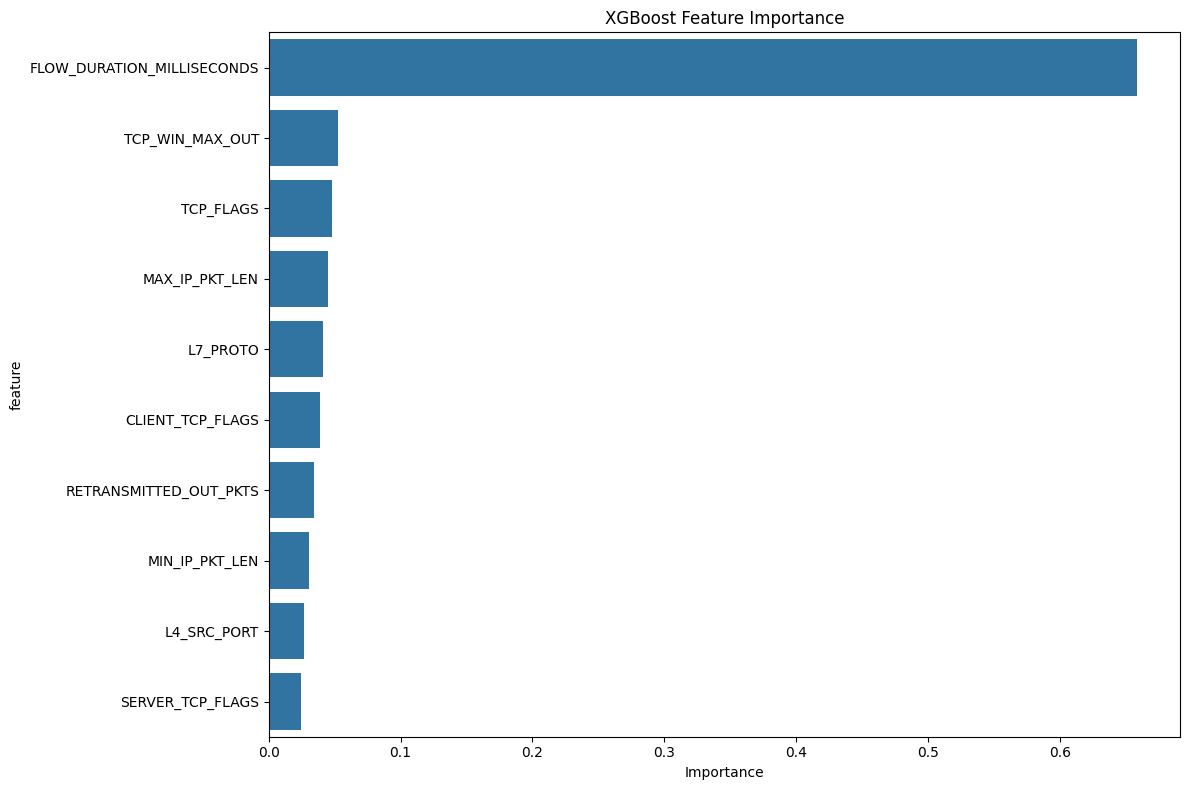

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost feature importance data from your earlier output
feature_importance_data = {
    'feature': [
        'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_OUT', 'TCP_FLAGS',
        'MAX_IP_PKT_LEN', 'L7_PROTO', 'CLIENT_TCP_FLAGS',
        'RETRANSMITTED_OUT_PKTS', 'MIN_IP_PKT_LEN', 'L4_SRC_PORT',
        'SERVER_TCP_FLAGS'
    ],
    'importance': [
        0.658330, 0.052222, 0.048136, 0.045131, 0.041092, 0.038929,
        0.034579, 0.030776, 0.026709, 0.024095
    ]
}

# Create DataFrame
feature_importance = pd.DataFrame(feature_importance_data)

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

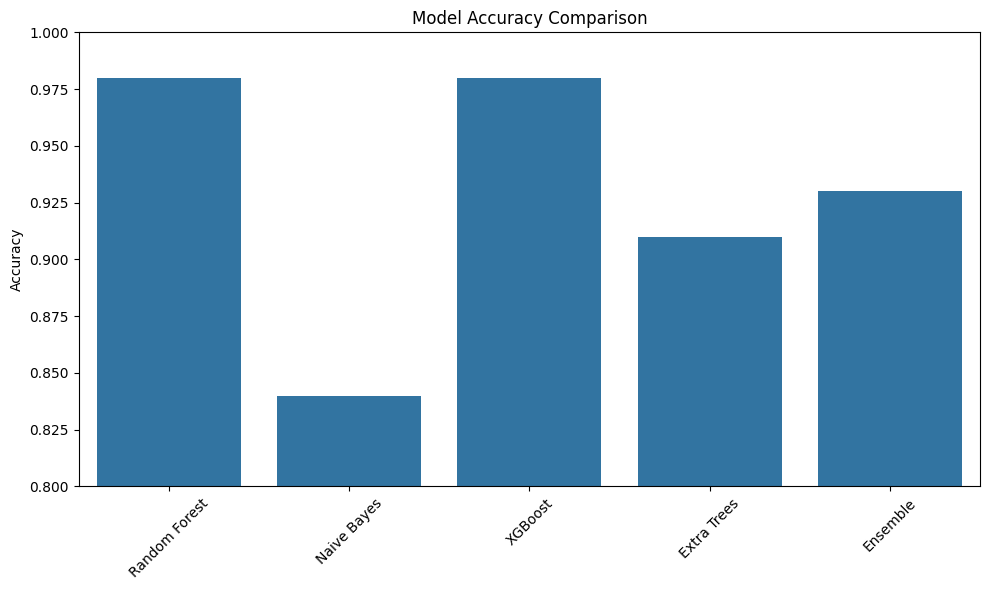

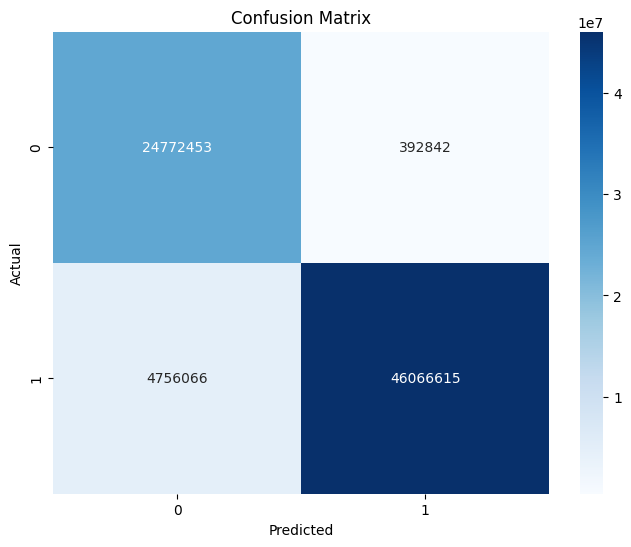

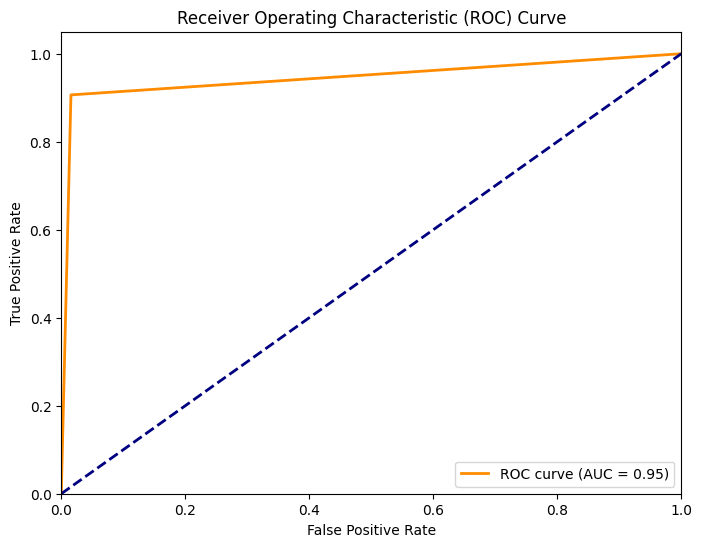

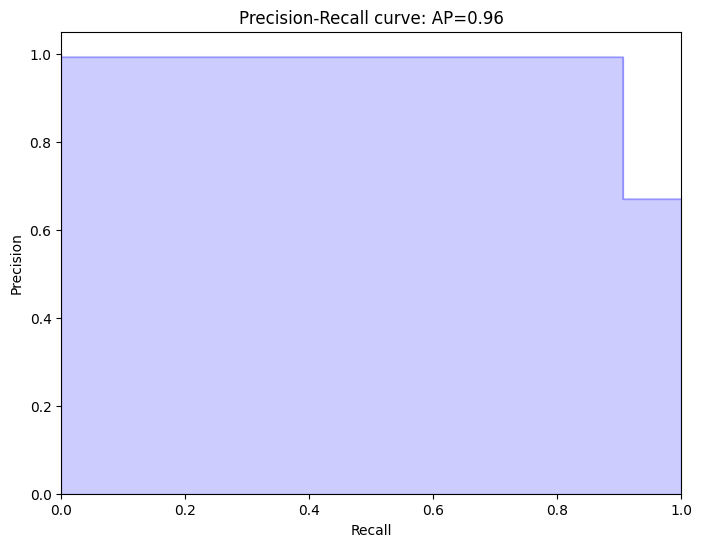

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming y_true and y_pred are your actual and predicted labels from the ensemble model

# 1. Model Accuracy Comparison
accuracies = {
    'Random Forest': 0.98,
    'Naive Bayes': 0.84,
    'XGBoost': 0.98,
    'Extra Trees': 0.91,
    'Ensemble': 0.93
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.show()